In [3]:
import sys
sys.path.append('/workspace/Documents')
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
import os
import math
import nibabel as nb
from scipy import ndimage
import CMR_HFpEF_Analysis.functions_collection as ff
import CMR_HFpEF_Analysis.data_simulation.transformation as transform
import CMR_HFpEF_Analysis.Image_utils as util


In [43]:
# load image
# filename = '/mnt/mount_zc_NAS/HFpEF/data/raw_data/155/HR_ED.nii.gz'
filename = '/mnt/mount_zc_NAS/HFpEF/data/processed_HR_data/2/ED/HR_ED_crop_60.nii.gz'
img_file = nb.load(filename)
header = img_file.header
spacing = img_file.header.get_zooms()
affine = img_file.affine
img = img_file.get_fdata()

print(img.shape,spacing)
print(affine)

(128, 128, 60) (1.25, 1.25, 2.0)
[[-5.97972807e-01 -5.19283440e-01  1.54735241e+00  6.88196869e+01]
 [-1.06317825e+00 -9.00340469e-09 -1.05181232e+00  2.73840302e+02]
 [-2.73094366e-01  1.13703329e+00  7.06676292e-01 -1.54285721e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


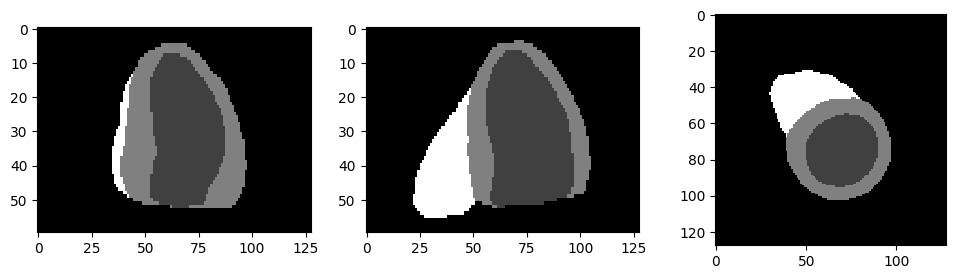

In [44]:
plt.figure(figsize = (12,3))
plt.subplot(131); plt.imshow(img[img.shape[0]//2, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img[:,img.shape[1]//2, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img[:,:,30], 'gray', aspect=spacing[0] / spacing[1])

trial 1: center the image data based on heart center and then convert the dimension to 64 x 128x 128

note: before we take the LR data into the model, we may need to center it according to the heart, and we shall record the movement vector in order to move the predicted HR data back.

In [4]:
center_mass = util.center_of_mass(img,0,large = True)
center_mass = [int(center_mass[0]),int(center_mass[1]),int(center_mass[2])]
center_image = [ img.shape[i] // 2 for i in range(0,len(img.shape))]
print(center_mass, center_image)

move = [ center_image[i] - center_mass[i] for i in range(0,len(center_mass))]
print(move)
img_move = util.move_3Dimage(img, move)
print(img_move.shape)

center_mass = util.center_of_mass(img_move,0,large = True)
print(center_mass)


img_move_nb = nb.Nifti1Image(img_move, affine, header=header)
nb.save(img_move_nb, os.path.join(os.path.dirname(filename),'HR_ED_move.nii.gz'))

# save move vector
np.save(os.path.join(os.path.dirname(filename),'move_heart_center'),np.asarray(move))
ff.txt_writer(os.path.join(os.path.dirname(filename),'move_heart_center.txt'),[[move[0]],[move[1]],[move[2]]],['x_move','y_move','z_move'])


[124, 142, 52] [141, 141, 49]
[17, -1, -3]
(283, 283, 99)
(141.6260226586379, 141.83044457052912, 49.06792100591174)


(283, 283, 99)
(283, 283, 64)
(128, 128, 64)


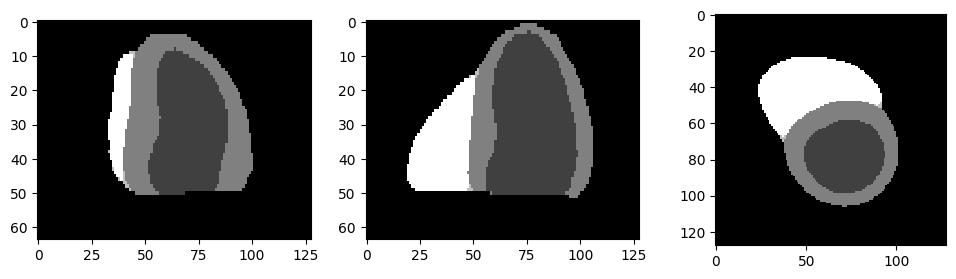

In [5]:
# convert dimension
img_move_file = nb.load(os.path.join(os.path.dirname(filename),'HR_ED_move.nii.gz'))
img_move_raw = img_move_file.get_fdata()
print(img_move_raw.shape)

# make sure when taking 64 slices it can cover the whole heart
z_slice_range = [int(img_move_raw.shape[-1]//2) - int(64/2) , int(img_move_raw.shape[-1]//2) + int(64/2) ]
assert np.sum(img_move_raw[:,:,z_slice_range[0] - 1]) == 0
assert np.sum(img_move_raw[:,:,z_slice_range[1]]) == 0

img_move = img_move_raw[ :, :, z_slice_range[0]:z_slice_range[1]]
print(img_move.shape)

img_move_crop = util.crop_or_pad(img_move,[128,128,64])
print(img_move_crop.shape)

plt.figure(figsize = (12,3))
plt.subplot(131); plt.imshow(img_move_crop[64, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img_move_crop[:,64, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img_move_crop[:,:,32], 'gray', aspect=spacing[0] / spacing[1])

img_move_crop_nb = nb.Nifti1Image(img_move_crop, affine, header=header)
nb.save(img_move_crop_nb, os.path.join(os.path.dirname(filename),'HR_ED_move_crop.nii.gz'))


trial 2: down-sample the HR data (2mm to 10mm, so factor = 5)

In [6]:
img_ds,new_affine = util.downsample_in_z(img_move_crop,5,affine=affine)
print(img_ds.shape)
new_spacing = (spacing[0],spacing[1],spacing[2]*5)

new_header = img_file.header
new_header['pixdim'] = [-1, new_spacing[0], new_spacing[1], new_spacing[-1],0,0,0,0]


img_ds_nb = nb.Nifti1Image(img_ds, new_affine, header=new_header)
nb.save(img_ds_nb, os.path.join(os.path.dirname(filename),'HR_ED_ds.nii.gz'))




(128, 128, 12)


Trial 3: in-plane motion generation

In [7]:
t_mu = 2.3
t_sigma = 0.87

img_new = np.zeros((img_ds.shape))


for i in range(0,img_ds.shape[-1]):
    I = img_ds[:,:,i]
    if np.sum(I) == 0:
        continue
    print('making slice: ',i)
    
    final_t_mm = transform.random_t(t_mu,t_sigma,img_ds[:,:,10],'normal')
    total_t_mm = math.sqrt(np.sum(np.square(np.asarray(final_t_mm))))
    final_t = [ final_t_mm[j] / spacing[j] for j in range(0,len(final_t_mm))]
    print(final_t_mm, total_t_mm,final_t)

    center_mass = util.center_of_mass(I,0,large = True)
    center_mass = [int(center_mass[0]),int(center_mass[1])]
    print(center_mass)

    translation,rotation,scale,M = transform.generate_transform_matrix(final_t,0.0,[1,1],I.shape)

    M = transform.transform_full_matrix_offset_heart(M, center_mass)

    II = transform.apply_affine_transform(I, M)
    img_new[:,:,i] = II

img_new_nb = nb.Nifti1Image(img_new, new_affine, header=new_header)
nb.save(img_new_nb, os.path.join(os.path.dirname(filename),'HR_ED_ds_moving_normal.nii.gz'))




making slice:  1
[-1.0042254349860527, -0.9317795814061696] 1.3699204037455546 [-0.8033803479888422, -0.7454236651249356]
[74, 61]
making slice:  2
[-1.5292743737353756, -1.240699040914326] 1.969267432394456 [-1.2234194989883005, -0.9925592327314607]
[72, 62]
making slice:  3
[1.970673687041743, 0.9511364138707551] 2.1881990902542707 [1.5765389496333944, 0.7609091310966041]
[70, 63]
making slice:  4
[-1.3174922214445903, 1.7644194866449046] 2.2020358485772364 [-1.0539937771556722, 1.4115355893159236]
[69, 63]
making slice:  5
[1.2366748727826455, 2.621950679942852] 2.898963626716409 [0.9893398982261165, 2.0975605439542813]
[66, 63]
making slice:  6
[2.5373186691208076, 2.4578889585935633] 3.532591706020544 [2.029854935296646, 1.9663111668748505]
[63, 63]
making slice:  7
[1.6810063908237796, 1.5746088055345906] 2.303296632320175 [1.3448051126590237, 1.2596870444276724]
[61, 63]
making slice:  8
[-3.1253722295244186, -0.5278816765855987] 3.1696388812540235 [-2.500297783619535, -0.422305

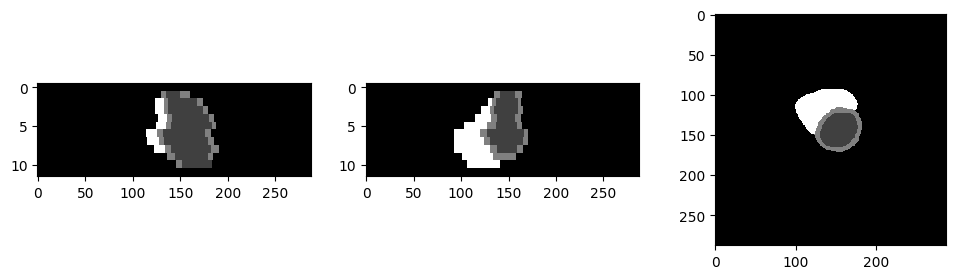

In [25]:
img_new = np.copy(img)
img_new[:,:,6] = II

plt.figure(figsize = (12,3))
plt.subplot(131); plt.imshow(img_new[img_new.shape[0]//2, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img_new[:,img_new.shape[1]//2, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img_new[:,:,6], 'gray', aspect=spacing[0] / spacing[1])

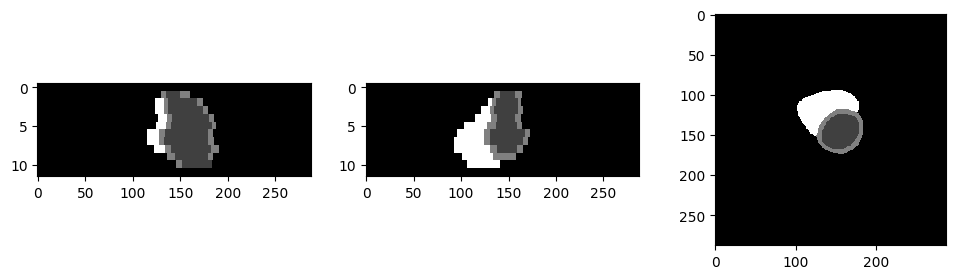

In [12]:
plt.figure(figsize = (12,3))
plt.subplot(131); plt.imshow(img[img.shape[0]//2, ...].T, 'gray', aspect=spacing[2] / spacing[1])
plt.subplot(132); plt.imshow(img[:,img.shape[1]//2, :].T, 'gray', aspect=spacing[2] / spacing[0])
plt.subplot(133); plt.imshow(img[:,:,6], 'gray', aspect=spacing[0] / spacing[1])